In [36]:
import rioxarray as rxr
import matplotlib.pyplot as plt
from working_sca_funcs import create_binary_chm, extract_dates, closest_date, calc_rgb
import geopandas as gpd
import numpy as np
from scipy.signal import convolve2d
import glob
import os
import pandas as pd
import xarray as xr
from datetime import datetime
import contextily
import rasterio as rio
import netCDF4
import cmcrameri.cm as cmc
import matplotlib.patches as patches
import numpy.ma as ma
from working_sca_funcs import create_binary_chm, extract_dates, closest_date, calc_rgb, create_validation_dataset, calculate_metrics

# categorical colorbar
from matplotlib import cm
from matplotlib.colors import ListedColormap

In [37]:
name = 'BUDD'
# Read shapefiles, create basin masks, and load validation dataset
# Read in basin shapefile and canopy mask
BS = f'/home/etboud/projects/data/basins/{name}/{name}_4326.geojson'
basin = gpd.read_file(BS).to_crs('EPSG:32611')
can = f'/home/etboud/projects/data/masks/4b_15img_ndvi_30_85_{name}_notclipped.tif'
mask = rxr.open_rasterio(can).rio.clip(basin.geometry.values, basin.crs, drop=True)
mask.values = np.where(mask.values>0, 0, 1)


# Load the bianry ASO dataset
aso_nc = f'/home/etboud/projects/data/stacks/extra/{name}_aso_projected.nc'
aso = xr.open_dataset(aso_nc)


In [3]:
# file = '/home/etboud/projects/data/stacks/BUDD_M1_2022_projected.nc'
# model = file.split('/')[-1].split('_')[1]
# code = 0
# year =2022

def get_masked_metrics(file,model, code, year):
    corr_fn = pd.read_csv('/home/etboud/projects/snow_mapping/corresponding_files_all.csv') # have not tested yet
    corr_fn = corr_fn[corr_fn['model_run']=='V5']
    corr_fn = corr_fn.drop(columns= ['model_file', 'model_run', 'raw_file','aso_file'])
    corr_fn = corr_fn[corr_fn['aso_date'].astype(str).str[:4]== str(year)]
    corr_fn = corr_fn.sort_values(by=corr_fn.columns.tolist())
    ps = xr.open_dataset(file)
    metrics = []
    for index, row in corr_fn.iterrows():
        times = ps['data'].time.values
        target_time = np.datetime64(row['ps_date'])

        matching_indices = np.where(times == target_time)[0]
        if len(matching_indices) == 0:
            # fallback, e.g. nearest match
            diffs = np.abs(times - target_time)
            matching_indices = [diffs.argmin()]
        model_slice = ps['data'].isel(time=matching_indices[0])     
        aso_slice = aso['data'].sel(time=pd.to_datetime(row['aso_date']))


        if model_slice.shape != aso_slice.shape:
            model_slice = model_slice[1]  # Not ideal; better to handle this more explicitly

        # if '2022-05-18T00:00:00.000000000' in row['ps_date']:
        #     model_slice = np.where(~sampled_mask.isnull())

        mask_array = mask.values[0]  # shape: (Y, X)

        if code == 0:
            condition = mask_array == 0 # canopy
        elif code == 1:
            condition = mask_array == 1 # open
        elif code == 2:
            condition = ~np.isnan(mask_array) # all
        else:
            raise ValueError(f"Unsupported code: {code}")

        model_slice_masked = np.where(condition, model_slice, np.nan)
        aso_slice_masked = np.where(condition, aso_slice, np.nan)

        # Create DataFrames for predicted (model) and observed (ASO) values
        ps_df = pd.DataFrame({
            'x': [x for x in range(model_slice_masked.shape[1]) for y in range(model_slice_masked.shape[0])],
            'y': [y for x in range(model_slice_masked.shape[1]) for y in range(model_slice_masked.shape[0])],
            'predict': model_slice_masked.flatten()
        })

        aso_df = pd.DataFrame({
            'x': [x for x in range(aso_slice_masked.shape[1]) for y in range(aso_slice_masked.shape[0])],
            'y': [y for x in range(aso_slice_masked.shape[1]) for y in range(aso_slice_masked.shape[0])],
            'obs': aso_slice_masked.flatten()
        })


        df = pd.merge(aso_df, ps_df, on=['x', 'y']).dropna()
        metrics_df = calculate_metrics(df)
        metrics_df['ps_date'] = row['ps_date']
        metrics_df['aso_date'] = row['aso_date']
        metrics_df['model'] = model
        metrics_df['year'] = year
        metrics_df['code'] = code
        metrics.append(metrics_df)

    return pd.concat(metrics, ignore_index=True)
    
def extract_file_metadata(filename):
    """Extract model and year from a filename."""
    basename = os.path.basename(filename)
    parts = basename.split('_')
    model = parts[1]
    year = parts[2]
    return model, year


def run_metrics_from_files(directory, target_codes=None):
    files = glob.glob(os.path.join(directory, f"{name}_*.nc"))
    print(files)
    all_results = []

    for file in files:
        model, year = extract_file_metadata(file)
        for code in [0,1,2]: 
            df = get_masked_metrics(file=file, model = model,code=code,year=year)
            
            all_results.append(df)

    return pd.concat(all_results, ignore_index=True)
        


In [14]:
df_all = run_metrics_from_files(
    directory='/home/etboud/projects/data/stacks/',
    target_codes=[0, 1, 2]
)

['/home/etboud/projects/data/stacks/DLNY_baseS_2022_3_50_NDVI_QAQC_spatial_test.nc', '/home/etboud/projects/data/stacks/DLNY_baseT_2022_QAQC_temporal.nc', '/home/etboud/projects/data/stacks/DLNY_baseST_2022_3_50_NDVI_QAQC_smoothing.nc', '/home/etboud/projects/data/stacks/DLNY_base_2022_projected.nc']


In [15]:

df_summary = df_all.groupby(['model', 'code', 'year']).mean(numeric_only=True)
df_summary.reset_index(inplace=True)

In [16]:
df_summary_full =df_summary

In [6]:
df_summary

,model,code,year,precision,recall,f1,sensitivity,specificity,balanced_accuracy,accuracy,kappa,TP,TN,FP,FN
0,base,0,2022,0.904402,0.507382,0.628836,0.507382,0.716226,0.611804,0.643162,0.154362,5.401887e+05,288804.142857,32408.571429,424259.571429
1,base,1,2022,0.812847,0.960034,0.879253,0.960034,0.535519,0.747776,0.837531,0.454399,3.070774e+05,99012.428571,65524.000000,11233.857143
2,base,2,2022,0.868133,0.629849,0.723622,0.629849,0.653873,0.641861,0.693790,0.226828,8.472661e+05,387816.571429,97932.571429,435493.428571
3,baseS,0,2022,0.889275,0.561191,0.668170,0.561191,0.650098,0.605644,0.684089,0.185199,6.331129e+05,285139.714286,43711.428571,380336.000000
4,baseS,1,2022,0.792613,0.960479,0.867325,0.960479,0.539546,0.750012,0.823040,0.539032,3.334123e+05,113091.142857,82631.571429,13370.000000
5,baseS,2,2022,0.853166,0.675151,0.749384,0.675151,0.619582,0.647367,0.724083,0.272656,9.665251e+05,398230.857143,126343.000000,393706.000000
6,baseST,0,2022,0.873522,0.588436,0.690906,0.588436,0.639005,0.613720,0.701107,0.187651,6.615561e+05,279539.142857,49312.000000,351892.714286
7,baseST,1,2022,0.786517,0.967066,0.865786,0.967066,0.527557,0.747311,0.820243,0.533872,3.353371e+05,109648.571429,86074.142857,11445.142857
8,baseST,2,2022,0.846060,0.697440,0.762366,0.697440,0.610562,0.654001,0.735398,0.276294,9.968933e+05,389187.714286,135386.142857,363337.857143
9,baseT,0,2022,0.885974,0.536170,0.654802,0.536170,0.700787,0.618478,0.663375,0.173629,6.016299e+05,288819.000000,40032.142857,411819.000000


In [ ]:
# df_summary = df_summary[df_summary['year']!=2022]

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 3))
# plt.rcParams['font.family'] = 'serif'

metrics = ['f1', 'balanced_accuracy','precision','recall']
years = ['2020','2022','2023']
bar_width = 0.2
groups = ['All Pixels']
codes = [2]
x = np.arange(len(metrics))

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 9), sharex=True)
plt.rcParams['font.family'] = 'serif'
# Color map per model group
base_colors = {'base': 'palegoldenrod', 'baseST': 'palegoldenrod','composite': 'mistyrose','compositeST': 'mistyrose'} #, 'M3': 'lightsteelblue'
models = ['base','baseST', 'composite','compositeST'] #'M3','M3ST'
bar_gap = 0.02  # Adjust gap between bars
for ax, year in zip(axs, years):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel(year, fontsize=14)
    # Axis limits and labels
    ax.set_ylim(0, 1)


    # Now plot the base models on top
    for j, model in enumerate(models):
        for i, metric in enumerate(metrics):

            xpos = x[i] + j * (bar_width+bar_gap)
            base_row = df_summary[(df_summary['code'] == 2) & 
                        (df_summary['model'] == model) & 
                        (df_summary['year'] == year)]
            if model.endswith('ST'):
                hatch = 'x'
            else:
                hatch = None
            if not base_row.empty:
                base_val = base_row[metric].values[0]
                ax.bar(xpos, base_val, width=bar_width,
                                        color=base_colors[model], 
                                        edgecolor='lightslategrey', alpha=0.9, linewidth=1.5, hatch=hatch,
                                        label=model if i == 0 else "")

                # Add difference text above bars
    for j, model in enumerate(models):
        for i, metric in enumerate(metrics):
            xpos = x[i] + j * (bar_width+bar_gap)
            base_row = df_summary[(df_summary['code'] == 2) & 
                        (df_summary['model'] == model) & 
                        (df_summary['year'] == year)]
            # pp_model = model + 'ST'
            # pp_row = df_summary[(df_summary['code'] == 2) & (df_summary['model'] == pp_model)]

            if not base_row.empty: # and not pp_row.empty:
                base_val = base_row[metric].values[0]
                # pp_val = pp_row[metric].values[0]
                # diff = base_val - pp_val
                
                # # Position text slightly above the taller bar
                max_height = base_val  # Use the scalar value directly
                ax.text(xpos, max_height + 0.02, f'{base_val:.2f}', ha='center', va='bottom', fontsize=10, color='black')
        
from matplotlib.patches import Patch

# Base model colors
base_colors = {'Base': 'palegoldenrod', 'Composite': 'mistyrose'}# , 'M3': 'lightsteelblue'}

# Legend elements
custom_legend = [
    # Base models (x hatch)
    Patch(facecolor=base_colors['Base'], edgecolor='lightslategrey', label='Base'),
    Patch(facecolor=base_colors['Composite'], edgecolor='lightslategrey', label='Composite'),
    #Patch(facecolor=base_colors['M3'], edgecolor='lightslategrey', hatch='x', label='M3'),
    
    # Post-processed models (o hatch)
    Patch(facecolor='white', edgecolor='lightslategrey', hatch='x', label='S+T Post-Processed')
]

# Apply custom legend
axs[0].legend(handles=custom_legend, title='Model Type', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12)
# X-axis ticks and labels
group_centers = x + (len(models) - 1) * bar_width / 2
ax.set_xticks(group_centers)
ax.set_xticklabels(metrics, fontsize=12)

# Axis limits and labels
ax.set_ylim(0, 1)
# ax.set_ylabel('F1 Score', fontsize=14)
# ax.set_title(f'Binary F1 Scores for Budd Basin {year}', fontsize=16,fontname='serif')

# Legend outside plot
# ax.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12)
# Remove box around plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

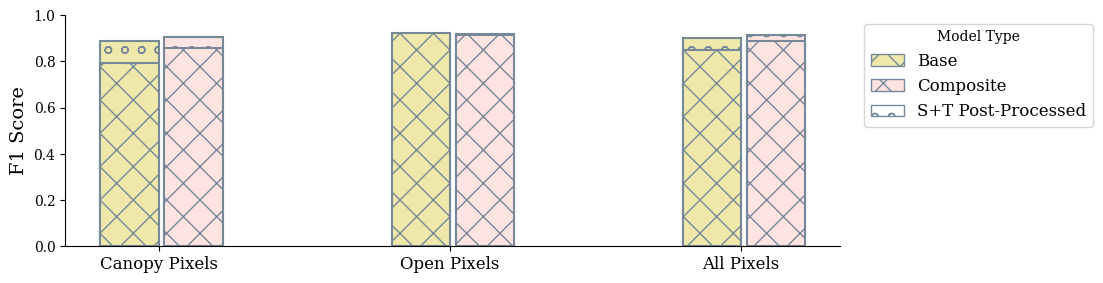

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
plt.rcParams['font.family'] = 'serif'

metric = 'f1'
bar_width = 0.2
groups = ['Canopy Pixels', 'Open Pixels', 'All Pixels']
codes = [0, 1, 2]
x = np.arange(len(codes))

# Color map per model group
base_colors = {'base': 'palegoldenrod', 'composite': 'mistyrose'} #, 'M3': 'lightsteelblue'
models = ['base', 'composite']
bar_gap = 0.02  # Adjust gap between bars
# Plot PP models in background first
for j, model in enumerate(models):
    for i, code in enumerate(codes):
        xpos = x[i] + j * (bar_width+bar_gap)
        pp_model = model + 'ST'
        pp_row = df_summary[(df_summary['code'] == code) & (df_summary['model'] == pp_model)]
        if not pp_row.empty:
            pp_val = pp_row[metric].values[0]
            ax.bar(xpos, pp_val, width=bar_width,
                    color=base_colors[model], alpha=1, linewidth = 1.5,hatch = 'o', label=model  if i == 0 else "",
                    edgecolor='lightslategrey')  # No edge for background

# Now plot the base models on top
for j, model in enumerate(models):
    for i, code in enumerate(codes):

        xpos = x[i] + j * (bar_width+bar_gap)
        base_row = df_summary[(df_summary['code'] == code) & (df_summary['model'] == model)]
        if not base_row.empty:
            base_val = base_row[metric].values[0]
            ax.bar(xpos, base_val, width=bar_width,
                    color=base_colors[model], alpha=1.0,
                    edgecolor='lightslategrey', hatch= 'x',linewidth=1.5,
                    label=model if i == 0 else "")
            # Add difference text above bars
for j, model in enumerate(models):
    for i, code in enumerate(codes):
        xpos = x[i] + j * (bar_width+bar_gap)
        base_row = df_summary[(df_summary['code'] == code) & (df_summary['model'] == model)]
        pp_model = model + 'PP'
        pp_row = df_summary[(df_summary['code'] == code) & (df_summary['model'] == pp_model)]

        if not base_row.empty and not pp_row.empty:
            base_val = base_row[metric].values[0]
            pp_val = pp_row[metric].values[0]
            diff = base_val - pp_val
            
            # Position text slightly above the taller bar
            max_height = max(base_val, pp_val)
            ax.text(xpos, max_height + 0.02, f'Δ:{-diff:.2f}', ha='center', va='bottom', fontsize=10, color='black')
            
from matplotlib.patches import Patch

# Base model colors
base_colors = {'Base': 'palegoldenrod', 'Composite': 'mistyrose'}# , 'M3': 'lightsteelblue'}

# Legend elements
custom_legend = [
    # Base models (x hatch)
    Patch(facecolor=base_colors['Base'], edgecolor='lightslategrey', hatch='x', label='Base'),
    Patch(facecolor=base_colors['Composite'], edgecolor='lightslategrey', hatch='x', label='Composite'),
    #Patch(facecolor=base_colors['M3'], edgecolor='lightslategrey', hatch='x', label='M3'),
    
    # Post-processed models (o hatch)
    Patch(facecolor='white', edgecolor='lightslategrey', hatch='o', label='S+T Post-Processed')
]

# Apply custom legend
ax.legend(handles=custom_legend, title='Model Type', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12)
# X-axis ticks and labels
group_centers = x + (len(models) - 1) * bar_width / 2
ax.set_xticks(group_centers)
ax.set_xticklabels(groups, fontsize=12)

# Axis limits and labels
ax.set_ylim(0, 1)
ax.set_ylabel('F1 Score', fontsize=14)
# ax.set_title(f'Binary F1 Scores for {name} Basin {year}', fontsize=16,fontname='serif')

# Legend outside plot
# ax.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12)
# Remove box around plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Text(0.5, 1.0, 'Median Binary Metrics for DLNY Basin')

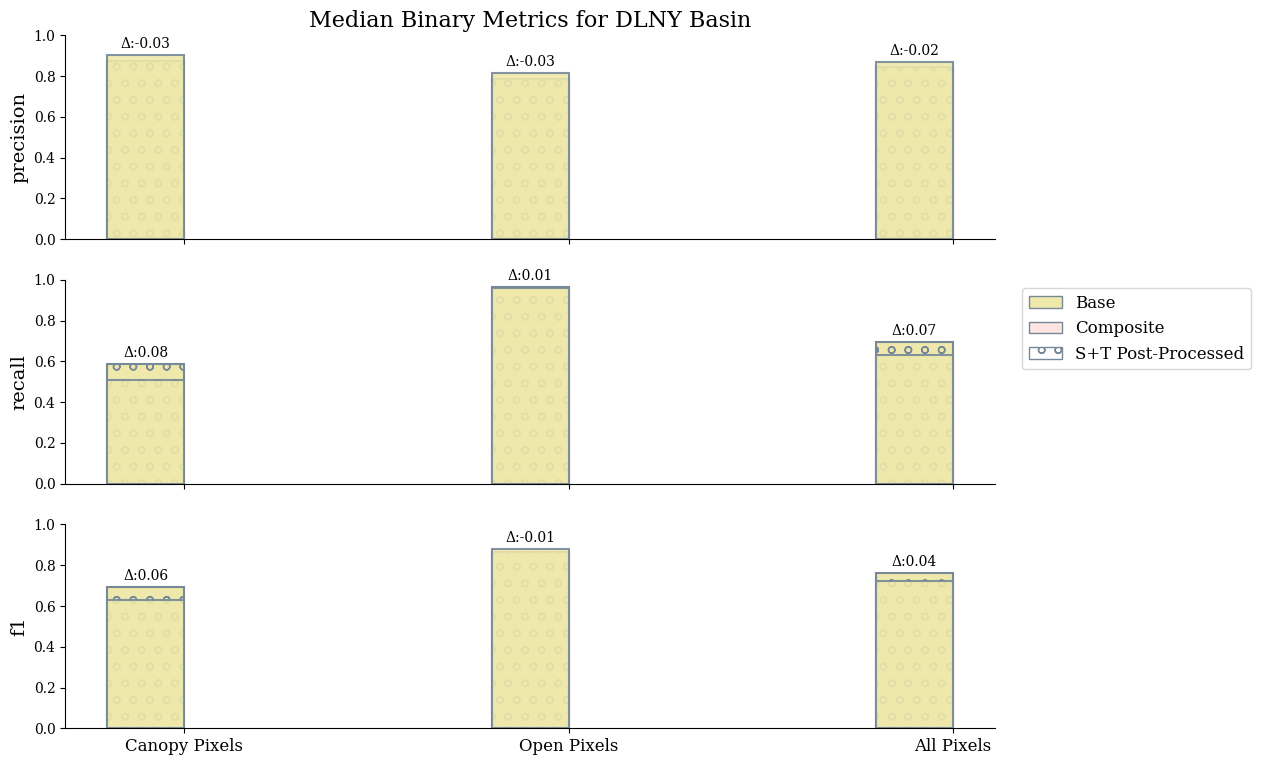

In [17]:
year = '2022'
#df_summary = df_summary.reset_index()
metrics = ['precision', 'recall', 'f1']  # You can change order as needed
bar_width = 0.2
base_colors = {'base': 'palegoldenrod', 'composite': 'mistyrose'} 
groups = ['Canopy Pixels', 'Open Pixels', 'All Pixels']
codes = [0, 1, 2]
x = np.arange(len(codes))

base_colors = {'base': 'palegoldenrod', 'composite': 'mistyrose'} #, 'M3': 'lightsteelblue'
models = ['base', 'composite']
bar_gap = 0.02  # Adjust gap between bars


fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 9), sharex=True)
plt.rcParams['font.family'] = 'serif'


for ax, metric in zip(axs, metrics):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel(metric, fontsize=14)
    # Axis limits and labels
    ax.set_ylim(0, 1)
    # Plot PP models first (background)
    for j, model in enumerate(['base', 'composite']):
        for i, code in enumerate([0, 1, 2]):
            xpos = x[i] + j * (bar_width + bar_gap)
            pp_model = model + 'ST'
            pp_row = df_summary[(df_summary['code'] == code) & (df_summary['model'] == pp_model)]
            if not pp_row.empty:
                pp_val = pp_row[metric].values[0]
                ax.bar(xpos, pp_val, width=bar_width,
                        color=base_colors[model],hatch='o',  edgecolor='lightslategrey', linewidth=1.5)

    # Plot base models on top
    for j, model in enumerate(models):
        for i, code in enumerate([0, 1, 2]):
            xpos = x[i] + j * (bar_width + bar_gap)
            base_row = df_summary[(df_summary['code'] == code) & (df_summary['model'] == model)]
            if not base_row.empty:
                base_val = base_row[metric].values[0]
                ax.bar(xpos, base_val, width=bar_width,
                        color=base_colors[model], alpha = .9,edgecolor='lightslategrey', linewidth=1.5)
                # Add difference text above bars
    for j, model in enumerate(models):
        for i, code in enumerate(codes):
            xpos = x[i] + j * (bar_width+bar_gap)
            base_row = df_summary[(df_summary['code'] == code) & (df_summary['model'] == model)]
            pp_model = model + 'ST'
            pp_row = df_summary[(df_summary['code'] == code) & (df_summary['model'] == pp_model)]

            if not base_row.empty and not pp_row.empty:
                base_val = base_row[metric].values[0]
                pp_val = pp_row[metric].values[0]
                diff = base_val - pp_val
                
                # Position text slightly above the taller bar
                max_height = max(base_val, pp_val)
                ax.text(xpos, max_height + 0.02, f'Δ:{-diff:.2f}', ha='center', va='bottom', fontsize=10, color='black')
            
from matplotlib.patches import Patch



# Legend elements
custom_legend = [
    # Base models (x hatch)
    Patch(facecolor=base_colors['base'], edgecolor='lightslategrey', label='Base'), #hatch='x',
    Patch(facecolor=base_colors['composite'], edgecolor='lightslategrey', label='Composite'),
    #Patch(facecolor=base_colors['M3'], edgecolor='lightslategrey', label='M3'),
    
    # Post-processed models (o hatch)
    Patch(facecolor='white', edgecolor='lightslategrey', hatch='o', label='S+T Post-Processed')
]

# Apply custom legend
axs[1].legend(handles=custom_legend, bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12)
# X-axis ticks and labels
group_centers = x + (len(models) - 1) * bar_width / 2
ax.set_xticks(group_centers)
ax.set_xticklabels(groups, fontsize=12)


axs[0].set_title(f'Median Binary Metrics for {name} Basin', fontsize=16,fontname='serif')





### Timeseries plot

In [8]:
def create_fsca_df(dataset):
    sca_df = []
    for t in range(len(dataset.time)):
        slice = dataset['data'].isel(time=t)
        fsca = (np.nansum(slice) / np.count_nonzero(~np.isnan(slice)))*100
        if fsca> 100:
            fsca = 100
        sca_df.append(fsca)    
    #create dataframe with fsca_list and corresponding dates
    dates = pd.to_datetime(dataset.time.values)
    df = pd.DataFrame({'date': dates, 'fsca': sca_df})
    return df
aso_df = create_fsca_df(aso)
# aso_df = aso_df[(aso_df['date'] > '2022-01-01') & (aso_df['date'] < '2023-01-01')].sort_values(by='date')
aso_df = aso_df[(aso_df['date'] > '2020-01-01') & (aso_df['date'] < '2022-01-01')].sort_values(by='date')

In [9]:
aso_df = create_fsca_df(aso)
aso_df

,date,fsca
0,2022-04-05,86.501150
1,2022-04-29,85.917005
2,2022-05-18,36.920212
3,2023-04-27,98.203262
4,2023-06-01,94.935869
5,2023-06-26,72.925793


In [ ]:
import cmcrameri.cm as cmc
aso_df = create_fsca_df(aso)
for year in [2020, 2022, 2023]:
    aso_yr = aso_df[(aso_df['date'] > f'{str(year)}-01-01') & (aso_df['date'] < f'{str(year + 1)}-01-01')].sort_values(by='date')
    fig, ax = plt.subplots(2,1, figsize=(11, 6))

    files = sorted(glob.glob(f'/home/etboud/projects/data/stacks/*{name}*base*{str(year)}*.nc'))
    n_colors = len(files)
    colors = [tuple(cmc.batlow(i / (n_colors - 1))) for i in range(n_colors)]
    labels = ['Base S+T', 'Base S', 'Base T', 'Base']
    ax[0].scatter(aso_yr['date'], aso_yr['fsca'], color='darkslategrey')
    for i, file in enumerate(files):

        temp = xr.open_dataset(file)
        temp_df = create_fsca_df(temp)
        #plot on the same plot
        m_name = os.path.basename(file).split('.')[0]
        ax[0].plot(temp_df['date'], temp_df['fsca'], label = labels[i], color = colors[i], linewidth=1.2,marker='o', markersize=3, alpha=0.8)
    ax[0].scatter(aso_yr['date'], aso_yr['fsca'], label = 'ASO', color='darkslategrey')
    ax[0].legend(loc='upper right', fontsize=12)
    ax[0].set_ylabel('Basin fSCA (%)', fontsize=14)
    ax[0].set_ylim(-5, 105)

    files = sorted(glob.glob(f'/home/etboud/projects/data/stacks/*{name}*composite*{str(year)}*.nc'))
    n_colors = len(files)
    colors = [tuple(cmc.batlow(i / (n_colors - 1))) for i in range(n_colors)]    # ax.scatter(temp_df['date'], temp_df['fsca'], color = colot, s = 3)
    labels = ['Composite S+T', 'Composite S', 'Composite T', 'Composite']
    ax[1].scatter(aso_yr['date'], aso_yr['fsca'],  color='darkslategrey')
    for i, file in enumerate(files):
        temp = xr.open_dataset(file)
        temp_df = create_fsca_df(temp)
        #plot on the same plot
        m_name = os.path.basename(file).split('.')[0]
        ax[1].plot(temp_df['date'], temp_df['fsca'], label = labels[i], color = colors[i], linewidth=1.2,marker='o', markersize=3, alpha=0.8)
    ax[1].scatter(aso_yr['date'], aso_yr['fsca'], label = 'ASO', color='darkslategrey')
    ax[1].legend(loc='upper right', fontsize=12)
    ax[1].set_ylabel(f'{year} Basin fSCA (%)', fontsize=14)
    ax[1].set_ylim(-5, 105)

(-5.0, 105.0)

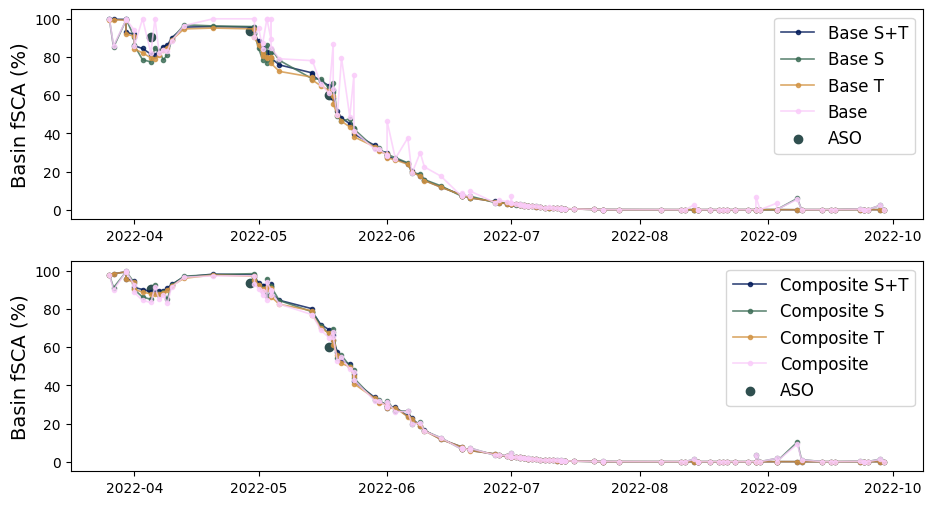

In [ ]:
import cmcrameri.cm as cmc
fig, ax = plt.subplots(2,1, figsize=(11, 6))

files = sorted(glob.glob('/home/etboud/projects/data/stacks/*{name}*base*2022*.nc'))
n_colors = len(files)
colors = [tuple(cmc.batlow(i / (n_colors - 1))) for i in range(n_colors)]
labels = ['Base S+T', 'Base S', 'Base T', 'Base']

for i, file in enumerate(files):

    temp = xr.open_dataset(file)
    temp_df = create_fsca_df(temp)
    #plot on the same plot
    m_name = os.path.basename(file).split('.')[0]
    ax[0].plot(temp_df['date'], temp_df['fsca'], label = labels[i], color = colors[i], linewidth=1.2,marker='o', markersize=3, alpha=0.8)
ax[0].scatter(aso_df['date'], aso_df['fsca'], label = 'ASO', color='darkslategrey')
ax[0].legend(loc='upper right', fontsize=12)
ax[0].set_ylabel('Basin fSCA (%)', fontsize=14)
ax[0].set_ylim(-5, 105)

files = sorted(glob.glob('/home/etboud/projects/data/stacks/*composite*2022*.nc'))
n_colors = len(files)
colors = [tuple(cmc.batlow(i / (n_colors - 1))) for i in range(n_colors)]    # ax.scatter(temp_df['date'], temp_df['fsca'], color = colot, s = 3)
labels = ['Composite S+T', 'Composite S', 'Composite T', 'Composite']
for i, file in enumerate(files):
    temp = xr.open_dataset(file)
    temp_df = create_fsca_df(temp)
    #plot on the same plot
    m_name = os.path.basename(file).split('.')[0]
    ax[1].plot(temp_df['date'], temp_df['fsca'], label = labels[i], color = colors[i], linewidth=1.2,marker='o', markersize=3, alpha=0.8)
ax[1].scatter(aso_df['date'], aso_df['fsca'], label = 'ASO', color='darkslategrey')
ax[1].legend(loc='upper right', fontsize=12)
ax[1].set_ylabel('Basin fSCA (%)', fontsize=14)
ax[1].set_ylim(-5, 105)

(-5.0, 105.0)

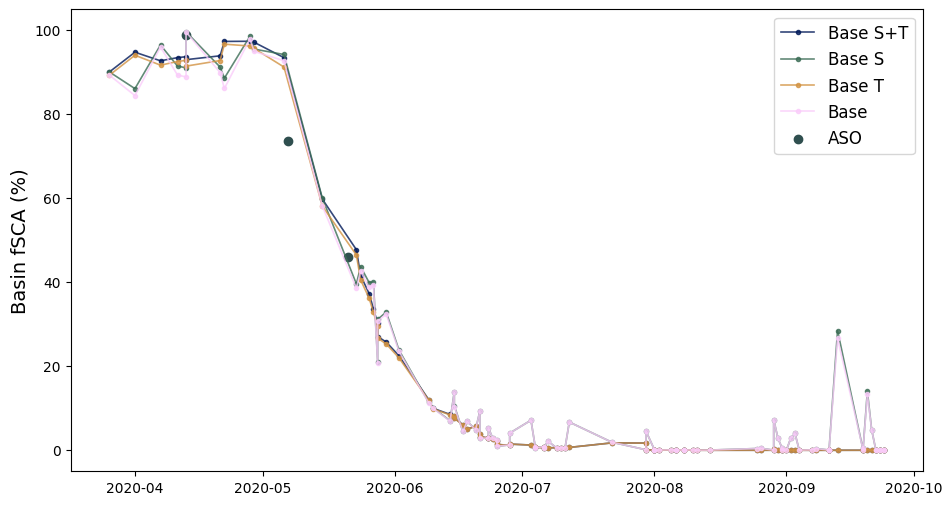

In [56]:
import cmcrameri.cm as cmc
fig, ax = plt.subplots(figsize=(11, 6))

files = sorted(glob.glob('/home/etboud/projects/data/stacks/*composite*2020*.nc'))
n_colors = len(files)
colors = [tuple(cmc.batlow(i / (n_colors - 1))) for i in range(n_colors)]
labels = ['Base S+T', 'Base S', 'Base T', 'Base']

for i, file in enumerate(files):

    temp = xr.open_dataset(file)
    temp_df = create_fsca_df(temp)
    #plot on the same plot
    m_name = os.path.basename(file).split('.')[0]
    ax.plot(temp_df['date'], temp_df['fsca'], label = labels[i], color = colors[i], linewidth=1.2,marker='o', markersize=3, alpha=0.8)
ax.scatter(aso_df['date'], aso_df['fsca'], label = 'ASO', color='darkslategrey')
ax.legend(loc='upper right', fontsize=12)
ax.set_ylabel('Basin fSCA (%)', fontsize=14)
ax.set_ylim(-5, 105)

In [59]:
test = xr.open_dataset('/home/etboud/projects/data/stacks/BUDD_composite_2020_projected.nc')
test_st = xr.open_dataset('/home/etboud/projects/data/stacks/BUDD_compositeST_2020_3_50_NDVI_QAQC_smoothing.nc')
test_s = xr.open_dataset('/home/etboud/projects/data/stacks/BUDD_compositeS_2020_3_50_NDVI_QAQC_spatial.nc')
test_t = xr.open_dataset('/home/etboud/projects/data/stacks/BUDD_compositeT_2020_QAQC_temporal.nc')
# test_test = xr.open_dataset('/home/etboud/projects/data/stacks/BUDD_composite_2022_3_50_NDVI_QAQC_spatial_test.nc')

In [ ]:
# plot data in tes 
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['lemonchiffon', 'lightblue'])
for t in range(len(test.time)):
    fig, axes = plt.subplots(1, 4, figsize=(11, 6))
    slice = test['data'].isel(time=t)
    slice_st = test_st['data'].isel(time=t)
    slice_s = test_s['data'].isel(time=t)
    slice_t = test_t['data'].isel(time=t)
    # slice_test = test_test['data'].isel(time=t)
    axes[0].imshow(slice, cmap=cmap)  # Optionally, specify a colormap
    axes[1].imshow(slice_s, cmap=cmap)  # Optionally, specify a colormap
    axes[2].imshow(slice_t, cmap=cmap)  # Optionally, specify a colormap
    axes[3].imshow(slice_st, cmap=cmap)  # Optionally, specify a colormap
    # axes[4].imshow(slice_test, cmap=cmap)  # Optionally, specify a colormap

    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('')
    axes[0].set_title(f"Time: {test.time.values[t]}")   

### DCE

In [38]:
dce_mask = rxr.open_rasterio('/home/etboud/projects/data/masks/dce_classes_budd.tif')

In [39]:
def get_dce_metrics(file,model, code, year):
    corr_fn = pd.read_csv('/home/etboud/projects/snow_mapping/corresponding_files_all.csv') # have not tested yet
    corr_fn = corr_fn[corr_fn['model_run']=='V5']
    corr_fn = corr_fn.drop(columns= ['model_file', 'model_run', 'raw_file','aso_file'])
    corr_fn = corr_fn[corr_fn['aso_date'].astype(str).str[:4]== str(year)]
    corr_fn = corr_fn.sort_values(by=corr_fn.columns.tolist())
    ps = xr.open_dataset(file)
    metrics = []
    for index, row in corr_fn.iterrows():
        times = ps['data'].time.values
        target_time = np.datetime64(row['ps_date'])

        matching_indices = np.where(times == target_time)[0]
        if len(matching_indices) == 0:
            # fallback, e.g. nearest match
            diffs = np.abs(times - target_time)
            matching_indices = [diffs.argmin()]
        model_slice = ps['data'].isel(time=matching_indices[0])     
        aso_slice = aso['data'].sel(time=pd.to_datetime(row['aso_date']))


        if model_slice.shape != aso_slice.shape:
            model_slice = model_slice[1]  # Not ideal; better to handle this more explicitly


        mask_array = dce_mask.values[0]  # shape: (Y, X)

        if code == -1:
            condition = mask_array == -1 # dense canopy
        elif code == 0:
            condition = mask_array == 0 # forest cluster
        elif code == 1:
            condition = mask_array == 1 # forest edge
        elif code == 2:
            condition = mask_array == 2 # small gaps
        elif code == 3:
            condition = mask_array == 3 # medium gaps
        elif code == 4:
            condition = mask_array == 4 # large gaps
        elif code == 5:
            condition = mask_array == 5 # small gaps
        elif code == 6:
            condition = mask_array == 6 # small gaps
        else:
            raise ValueError(f"Unsupported code: {code}")

        model_slice_masked = np.where(condition, model_slice, np.nan)
        aso_slice_masked = np.where(condition, aso_slice, np.nan)

        # Create DataFrames for predicted (model) and observed (ASO) values
        ps_df = pd.DataFrame({
            'x': [x for x in range(model_slice_masked.shape[1]) for y in range(model_slice_masked.shape[0])],
            'y': [y for x in range(model_slice_masked.shape[1]) for y in range(model_slice_masked.shape[0])],
            'predict': model_slice_masked.flatten()
        })

        aso_df = pd.DataFrame({
            'x': [x for x in range(aso_slice_masked.shape[1]) for y in range(aso_slice_masked.shape[0])],
            'y': [y for x in range(aso_slice_masked.shape[1]) for y in range(aso_slice_masked.shape[0])],
            'obs': aso_slice_masked.flatten()
        })


        df = pd.merge(aso_df, ps_df, on=['x', 'y']).dropna()
        metrics_df = calculate_metrics(df)
        metrics_df['ps_date'] = row['ps_date']
        metrics_df['aso_date'] = row['aso_date']
        metrics_df['model'] = model
        metrics_df['year'] = year
        metrics_df['code'] = code
        metrics.append(metrics_df)

    return pd.concat(metrics, ignore_index=True)
    
def extract_file_metadata(filename):
    """Extract model and year from a filename."""
    basename = os.path.basename(filename)
    parts = basename.split('_')
    model = parts[1]
    year = parts[2]
    return model, year


def run_metrics_from_files(directory, target_codes=None):
    files = glob.glob(os.path.join(directory, f"BUDD_*.nc"))
    print(files)
    all_results = []

    for file in files:
        model, year = extract_file_metadata(file)
        for code in [-1,0,1,2,3,4,5,6]: 
            df = get_dce_metrics(file=file, model = model,code=code,year=year)
            
            all_results.append(df)

    return pd.concat(all_results, ignore_index=True)

In [70]:
dce_all = run_metrics_from_files(
    directory='/home/etboud/projects/data/stacks/sep/',
    target_codes=[-1,0, 1, 2,3,4,5,6]
)

['/home/etboud/projects/data/stacks/sep/BUDD_base_2020_projected.nc', '/home/etboud/projects/data/stacks/sep/BUDD_composite_2020_projected.nc', '/home/etboud/projects/data/stacks/sep/BUDD_baseS_2022_3_50_NDVI_QAQC_spatial.nc', '/home/etboud/projects/data/stacks/sep/BUDD_compositeS_2022_3_50_NDVI_QAQC_spatial.nc', '/home/etboud/projects/data/stacks/sep/BUDD_baseST_2020_3_50_NDVI_QAQC_smoothing.nc', '/home/etboud/projects/data/stacks/sep/BUDD_baseS_2023_3_50_NDVI_QAQC_spatial.nc', '/home/etboud/projects/data/stacks/sep/BUDD_base_2022_projected.nc', '/home/etboud/projects/data/stacks/sep/BUDD_base_2023_projected.nc', '/home/etboud/projects/data/stacks/sep/BUDD_composite_2022_projected.nc', '/home/etboud/projects/data/stacks/sep/BUDD_composite_2023_projected.nc', '/home/etboud/projects/data/stacks/sep/BUDD_baseS_2020_3_50_NDVI_QAQC_spatial.nc', '/home/etboud/projects/data/stacks/sep/BUDD_baseST_2023_3_50_NDVI_QAQC_smoothing.nc']


In [71]:
dce_all = dce_all.drop_duplicates()
backup = dce_all


The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [72]:
dce_all = dce_all[(dce_all['model']=='base')|(dce_all['model']=='baseS')|(dce_all['model']=='composite')]

In [74]:
dce_all

,precision,recall,f1,sensitivity,specificity,balanced_accuracy,accuracy,kappa,TP,TN,FP,FN,ps_date,aso_date,model,year,code
0,0.998512,0.702364,0.824656,0.702364,0.066667,0.384515,0.701652,-0.001729,103343,11,154,43793,2020-04-13,2020-04-13,base,2020,-1
1,0.673942,0.672680,0.673311,0.672680,0.470289,0.571485,0.595656,0.142584,61413,26379,29712,29883,2020-05-06,2020-05-07,base,2020,-1
2,0.551006,0.043297,0.080285,0.043297,0.995185,0.519241,0.880868,0.063905,767,129169,625,16948,2020-05-23,2020-05-21,base,2020,-1
3,0.998009,0.837942,0.910998,0.837942,0.183432,0.510687,0.836605,0.000494,69183,31,138,13380,2020-04-13,2020-04-13,base,2020,0
4,0.648222,0.790644,0.712385,0.790644,0.415482,0.603063,0.631832,0.213929,37792,14578,20509,10007,2020-05-06,2020-05-07,base,2020,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,0.879278,0.995214,0.933661,0.995214,0.362017,0.678616,0.883522,0.471214,150769,11746,20700,725,2020-05-06,2020-05-07,baseS,2020,5
460,0.945225,0.805230,0.869629,0.805230,0.839481,0.822355,0.812944,0.546046,114755,34778,6650,27757,2020-05-23,2020-05-21,baseS,2020,5
461,0.991805,0.955510,0.973319,0.955510,0.027716,0.491613,0.948036,-0.005185,106138,25,877,4942,2020-04-13,2020-04-13,baseS,2020,6
462,0.899669,0.999060,0.946763,0.999060,0.289132,0.644096,0.902868,0.410061,96718,4387,10786,91,2020-05-06,2020-05-07,baseS,2020,6


In [75]:
# get summary on dce all
dce_summary = dce_all.groupby(['model', 'code']).mean(numeric_only=True)

In [76]:
dce_summary

precision    recall        f1  sensitivity  specificity  \
model     code                                                            
base      -1     0.906098  0.468993  0.567549     0.468993     0.550394   
           0     0.869168  0.685428  0.736535     0.685428     0.523230   
           1     0.886556  0.782724  0.817222     0.782724     0.549311   
           2     0.903043  0.882748  0.887040     0.882748     0.499370   
           3     0.908695  0.931265  0.916081     0.931265     0.500231   
           4     0.908686  0.945471  0.923344     0.945471     0.501137   
           5     0.910545  0.959120  0.932152     0.959120     0.452250   
           6     0.922556  0.976691  0.947744     0.976691     0.383605   
baseS     -1     0.905271  0.525736  0.609467     0.525736     0.477485   
           0     0.862595  0.749519  0.772134     0.749519     0.436984   
           1     0.879566  0.831343  0.842122     0.831343     0.478213   
           2     0.895914  0.904141  0.894626     0.904141     0.449034   
           3     0.903534  0.938825  0.917346     0.938825     0.456099   
           4     0.906415  0.948538  0.923976     0.948538     0.458302   
           5     0.905558  0.960344  0.930303     0.960344     0.426545   
           6     0.921743  0.977420  0.947838     0.977420     0.369564   
composite -1     0.889362  0.610700  0.684482     0.610700     0.423803   
           0     0.845357  0.823620  0.818979     0.823620     0.374142   
           1     0.859174  0.897198  0.870586     0.897198     0.411487   
           2     0.879856  0.929639  0.900622     0.929639     0.408157   
           3     0.899435  0.931426  0.912835     0.931426     0.445525   
           4     0.910040  0.936373  0.920323     0.936373     0.466853   
           5     0.909497  0.951346  0.927592     0.951346     0.445816   
           6     0.924808  0.971880  0.946413     0.971880     0.401685   

                balanced_accuracy  accuracy     kappa             TP  \
model     code                                                         
base      -1             0.509693  0.586761  0.039003   60325.000000   
           0             0.604329  0.752673  0.104974   43541.307692   
           1             0.666017  0.806831  0.187292   64143.692308   
           2             0.691059  0.856227  0.278826   49863.692308   
           3             0.715748  0.880723  0.335876   33168.384615   
           4             0.723304  0.884563  0.336464   42623.307692   
           5             0.705685  0.889537  0.320216  113103.230769   
           6             0.680148  0.911012  0.303321   72162.692308   
baseS     -1             0.501610  0.624902  0.047627   69948.384615   
           0             0.593251  0.780301  0.153269   52387.307692   
           1             0.654778  0.825857  0.258825   76475.846154   
           2             0.676587  0.861552  0.359657   58816.153846   
           3             0.697462  0.879593  0.431898   39686.538462   
           4             0.703420  0.882988  0.446939   52878.923077   
           5             0.693445  0.884459  0.433951  146796.692308   
           6             0.673492  0.909554  0.404034   94110.307692   
composite -1             0.517251  0.683851  0.057778   80101.923077   
           0             0.598881  0.810366  0.148390   56466.769231   
           1             0.654342  0.847378  0.263838   81235.769231   
           2             0.668898  0.866891  0.353611   60264.923077   
           3             0.688475  0.874943  0.406838   39473.615385   
           4             0.701613  0.879916  0.429523   52334.384615   
           5             0.698581  0.881506  0.423988  145533.000000   
           6             0.686782  0.907967  0.417234   93597.153846   

                          TN            FP            FN  
model     code                                            
base      -1    23267.307692   3451.076923  56148.000000  
           0   

/tmp/ipykernel_3783006/483359565.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Base', 'Base + Spatial PP', 'Composite'], fontsize=14)


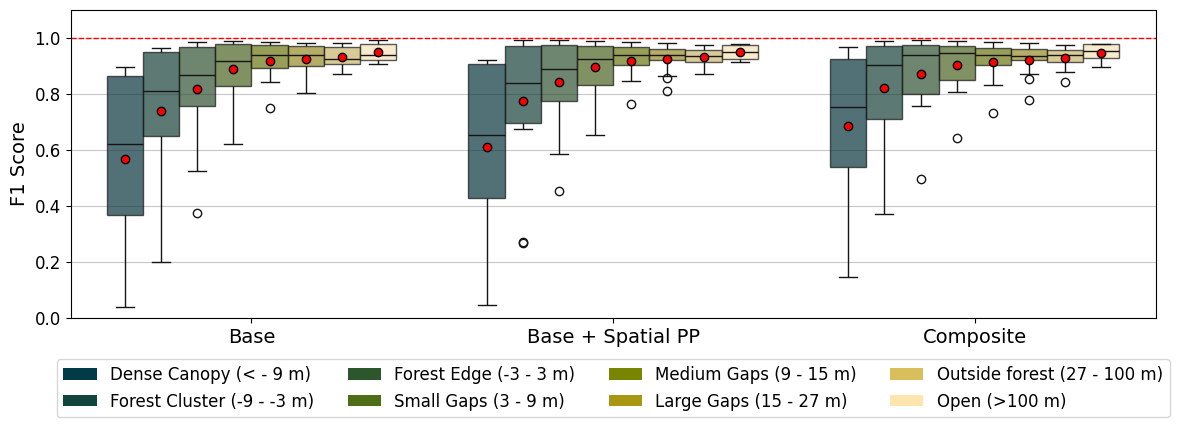

In [ ]:
import seaborn as sns
import cmcrameri.cm as cmc
from matplotlib.patches import Patch
plt.rcParams['font.family'] = 'serif'
# set fig size
model_order = ['base', 'baseS', 'composite']
fig, ax = plt.subplots(figsize=(14, 4))
sns.boxplot(
    x=dce_all['model'],
    y=dce_all['f1'],
    hue=dce_all['code'],
    order = model_order,
    palette=cmc.bamako, showmeans=True,
    meanprops={"marker":"o","markerfacecolor":"red", "markeredgecolor":"black"}
)


for patch in ax.patches:
    patch.set_alpha(0.7)
#add horizontal red dashed line
ax.axhline(y=1, color='red', linestyle='--', linewidth=1)
# set y lim
ax.set_ylim(0, 1.1)
ax.set_xlabel('', fontsize=14)
ax.set_xticklabels(['Base', 'Base + Spatial PP', 'Composite'], fontsize=14)
ax.set_ylabel('F1 Score', fontsize=14)
colors = [cmc.bamako(i / (len(dce_all['code'].unique()) - 1)) for i in range(len(dce_all['code'].unique()))]
labels = ['Dense Canopy (< - 9 m)', 'Forest Cluster (-9 - -3 m)', 'Forest Edge (-3 - 3 m)', 'Small Gaps (3 - 9 m)', 'Medium Gaps (9 - 15 m)', 'Large Gaps (15 - 27 m)', 'Outside forest (27 - 100 m)', 'Open (>100 m)']
# Create custom legend
custom_legend = [
    Patch(facecolor=colors[i], label=labels[i]) for i in range(len(labels))
]
ax.legend(handles=custom_legend, loc='lower center', fontsize=12, ncol = 4, bbox_to_anchor=(0.5, -0.35), frameon=True)
# add background horizontal lines
ax.yaxis.grid(True, linestyle='-', alpha=0.7)


/tmp/ipykernel_3658922/2833029413.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(labels)


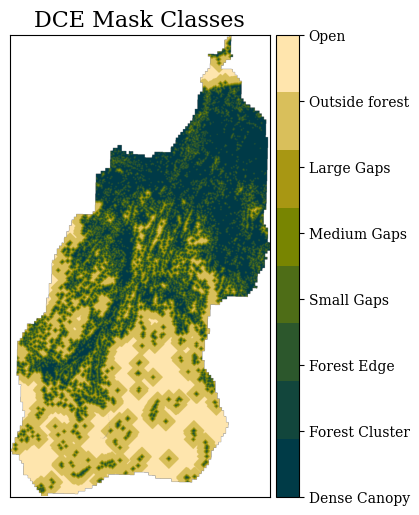

In [65]:
# plot dce_mask with cmc.bamako colormap
fig, ax = plt.subplots(figsize=(8, 6))



# categorical colorbar
from matplotlib import cm
from matplotlib.colors import ListedColormap

colors = [cmc.bamako(i / (len(dce_all['code'].unique()) - 1)) for i in range(len(dce_all['code'].unique()))]
labels = ['Dense Canopy', 'Forest Cluster', 'Forest Edge', 'Small Gaps', 'Medium Gaps', 'Large Gaps', 'Outside forest', 'Open']
cmap = ListedColormap(colors)
im = plt.imshow(dce_mask.values[0], cmap=cmap, vmin=-1, vmax=6)

cbar = fig.colorbar(im, ax=ax, pad=0.01)
cbar.ax.set_yticklabels(labels)

plt.title('DCE Mask Classes', fontsize=16)
plt.xticks([])
plt.yticks([])
plt.show()

In [40]:
def get_masked_metrics(file,model, code, year, radius, threshold):
    corr_fn = pd.read_csv('/home/etboud/projects/snow_mapping/corresponding_files_all.csv') # have not tested yet
    corr_fn = corr_fn[corr_fn['model_run']=='V5']
    corr_fn = corr_fn.drop(columns= ['model_file', 'model_run', 'raw_file','aso_file'])
    corr_fn = corr_fn[corr_fn['aso_date'].astype(str).str[:4]== str(year)]
    corr_fn = corr_fn.sort_values(by=corr_fn.columns.tolist())
    ps = xr.open_dataset(file)
    metrics = []
    for index, row in corr_fn.iterrows():
        times = ps['data'].time.values
        target_time = np.datetime64(row['ps_date'])

        matching_indices = np.where(times == target_time)[0]
        if len(matching_indices) == 0:
            # fallback, e.g. nearest match
            diffs = np.abs(times - target_time)
            matching_indices = [diffs.argmin()]
        model_slice = ps['data'].isel(time=matching_indices[0])     
        aso_slice = aso['data'].sel(time=pd.to_datetime(row['aso_date']))


        if model_slice.shape != aso_slice.shape:
            model_slice = model_slice[1]  # Not ideal; better to handle this more explicitly

        # if '2022-05-18T00:00:00.000000000' in row['ps_date']:
        #     model_slice = np.where(~sampled_mask.isnull())

        mask_array = mask.values[0]  # shape: (Y, X)

        if code == 0:
            condition = mask_array == 0 # canopy
        elif code == 1:
            condition = mask_array == 1 # open
        elif code == 2:
            condition = ~np.isnan(mask_array) # all
        else:
            raise ValueError(f"Unsupported code: {code}")

        model_slice_masked = np.where(condition, model_slice, np.nan)
        aso_slice_masked = np.where(condition, aso_slice, np.nan)

        # Create DataFrames for predicted (model) and observed (ASO) values
        ps_df = pd.DataFrame({
            'x': [x for x in range(model_slice_masked.shape[1]) for y in range(model_slice_masked.shape[0])],
            'y': [y for x in range(model_slice_masked.shape[1]) for y in range(model_slice_masked.shape[0])],
            'predict': model_slice_masked.flatten()
        })

        aso_df = pd.DataFrame({
            'x': [x for x in range(aso_slice_masked.shape[1]) for y in range(aso_slice_masked.shape[0])],
            'y': [y for x in range(aso_slice_masked.shape[1]) for y in range(aso_slice_masked.shape[0])],
            'obs': aso_slice_masked.flatten()
        })


        df = pd.merge(aso_df, ps_df, on=['x', 'y']).dropna()
        # Calculate the number of each class (0, 1, 2) in the predictions and observations
        pred_ones = np.sum(df['predict'] == 1)
        pred_zeros = np.sum(df['predict'] == 0)
        pred_twos = np.sum(df['predict'] == 2)
        pred_sca = pred_ones / (pred_ones + pred_zeros + pred_twos)

        obs_ones = np.sum(df['obs'] == 1)
        obs_zeros = np.sum(df['obs'] == 0)
        obs_twos = np.sum(df['obs'] == 2)
        obs_sca = obs_ones / (obs_ones + obs_zeros + obs_twos) 
        metrics_df = calculate_metrics(df)
        metrics_df['ps_date'] = row['ps_date']
        metrics_df['aso_date'] = row['aso_date']
        metrics_df['model'] = model
        metrics_df['year'] = year
        metrics_df['code'] = code
        metrics_df['threshold'] = threshold 
        metrics_df['radius'] = radius
        # Append additional metrics
        metrics_df['pred_sca'] = pred_sca
        metrics_df['obs_sca'] = obs_sca
        metrics_df['threshold'] = threshold
        metrics_df['radius'] = radius
        metrics.append(metrics_df)

    return pd.concat(metrics, ignore_index=True)
    
def extract_file_metadata(filename):
    """Extract model and year from a filename."""
    basename = os.path.basename(filename)
    parts = basename.split('_')
    model = parts[1]
    if model.endswith('S'):
        radius = parts[3]
        threshold = parts[4]
    else:
        radius = 'NA'
        threshold = 'NA'
    year = parts[2]
    return model, year, radius, threshold


def run_metrics_from_files(directory, target_codes=None):
    files = glob.glob(os.path.join(directory, f"{name}*baseS_*.nc"))
    print(files)
    all_results = []

    for file in files:
        model, year,radius, threshold = extract_file_metadata(file)
        for code in target_codes: 
            df = get_masked_metrics(file=file, model = model,code=code,year=year, radius=radius, threshold=threshold)
            
            all_results.append(df)

    return pd.concat(all_results, ignore_index=True)

In [41]:
df_all = run_metrics_from_files(
    directory='/home/etboud/projects/data/stacks/',
    target_codes=[0]
)

['/home/etboud/projects/data/stacks/BUDD_baseS_2022_1_10_NDVI_QAQC.nc', '/home/etboud/projects/data/stacks/BUDD_baseS_2022_10_70_NDVI_QAQC.nc', '/home/etboud/projects/data/stacks/BUDD_baseS_2022_10_30_NDVI_QAQC.nc', '/home/etboud/projects/data/stacks/BUDD_baseS_2022_10_10_NDVI_QAQC.nc', '/home/etboud/projects/data/stacks/BUDD_baseS_2022_15_30_NDVI_QAQC.nc', '/home/etboud/projects/data/stacks/BUDD_baseS_2022_3_10_NDVI_QAQC.nc', '/home/etboud/projects/data/stacks/BUDD_baseS_2022_15_70_NDVI_QAQC.nc', '/home/etboud/projects/data/stacks/BUDD_baseS_2022_1_35_NDVI_QAQC.nc', '/home/etboud/projects/data/stacks/BUDD_baseS_2022_15_90_NDVI_QAQC.nc', '/home/etboud/projects/data/stacks/BUDD_baseS_2022_5_90_NDVI_QAQC.nc', '/home/etboud/projects/data/stacks/BUDD_baseS_2022_1_70_NDVI_QAQC.nc', '/home/etboud/projects/data/stacks/BUDD_baseS_2022_3_30_NDVI_QAQC.nc', '/home/etboud/projects/data/stacks/BUDD_baseS_2022_1_30_NDVI_QAQC.nc', '/home/etboud/projects/data/stacks/BUDD_baseS_2022_3_90_NDVI_QAQC.nc',

In [28]:
df_all

,precision,recall,f1,sensitivity,specificity,balanced_accuracy,accuracy,kappa,TP,TN,...,FN,ps_date,aso_date,model,year,code,threshold,radius,pred_sca,obs_sca
0,0.966201,1.000000,0.982810,1.000000,0.000000,0.500000,0.966201,0.000000,439889,0,...,0,2022-04-03,2022-04-05,baseS,2022,0,10,1,1.000000,0.966201
1,0.966201,1.000000,0.982810,1.000000,0.000000,0.500000,0.966201,0.000000,439889,0,...,0,2022-04-05,2022-04-05,baseS,2022,0,10,1,1.000000,0.966201
2,0.966201,1.000000,0.982810,1.000000,0.000000,0.500000,0.966201,0.000000,439889,0,...,0,2022-04-07,2022-04-05,baseS,2022,0,10,1,1.000000,0.966201
3,0.960095,1.000000,0.979641,1.000000,0.000000,0.500000,0.960095,0.000000,437109,0,...,0,2022-04-29,2022-04-29,baseS,2022,0,10,1,1.000000,0.960095
4,0.960095,1.000000,0.979641,1.000000,0.000000,0.500000,0.960095,0.000000,437109,0,...,0,2022-04-30,2022-04-29,baseS,2022,0,10,1,1.000000,0.960095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,0.969118,0.747125,0.843764,0.747125,0.319405,0.533265,0.732668,0.015994,328652,4915,...,111237,2022-04-07,2022-04-05,baseS,2022,0,70,3,0.744876,0.966201
94,0.967925,0.935108,0.951233,0.935108,0.254458,0.594783,0.907946,0.136289,408744,4623,...,28365,2022-04-29,2022-04-29,baseS,2022,0,70,3,0.927543,0.960095
95,0.967925,0.935108,0.951233,0.935108,0.254458,0.594783,0.907946,0.136289,408744,4623,...,28365,2022-04-30,2022-04-29,baseS,2022,0,70,3,0.927543,0.960095
96,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,...,0,2022-05-18,2022-05-18,baseS,2022,0,70,3,0.000000,0.564228


In [ ]:
# #sort metrics based on threshold and radius
# #drop row with na for threshold and radius
# df_all = df_all.dropna(subset=['threshold', 'radius'])
# df_all['threshold'] = df_all['threshold'].astype(float)
# df_all['radius'] = df_all['radius'].astype(float)
# df_all = df_all.sort_values(by=['threshold', 'radius'])

In [43]:
#drop 2022-04-03, 2022-05-07
df_all = df_all[df_all['ps_date'] != '2022-04-03']
df_all = df_all[df_all['ps_date'] != '2022-04-05']
df_all = df_all[df_all['ps_date'] != '2022-04-29']
df_all = df_all[df_all['ps_date'] != '2022-05-18']
#drop anythign with f1 scor eof 0
df_all = df_all[df_all['f1'] > 0]

In [44]:
metrics = df_all

In [48]:
# sort metrics by date

metrics = metrics.sort_values(by='ps_date')
#sort by threshold
metrics = metrics.sort_values(by='threshold')

In [49]:
metrics


,precision,recall,f1,sensitivity,specificity,balanced_accuracy,accuracy,kappa,TP,TN,...,FN,ps_date,aso_date,model,year,code,threshold,radius,pred_sca,obs_sca
2,0.966201,1.000000,0.982810,1.000000,0.000000,0.500000,0.966201,0.000000,439889,0,...,0,2022-04-07,2022-04-05,baseS,2022,0,10,1,1.000000,0.966201
34,0.709998,0.736620,0.723064,0.736620,0.610433,0.673526,0.681631,0.348981,189223,121108,...,67657,2022-05-19,2022-05-18,baseS,2022,0,10,3,0.585384,0.564228
81,0.960354,0.995063,0.977400,0.995063,0.011669,0.503366,0.955820,0.011541,434951,212,...,2158,2022-04-30,2022-04-29,baseS,2022,0,10,15,0.994794,0.960095
74,0.963239,0.984494,0.973750,0.984494,0.096048,0.540271,0.949040,0.108023,430331,1745,...,6778,2022-04-30,2022-04-29,baseS,2022,0,10,5,0.981280,0.960095
83,0.686553,0.776728,0.728862,0.776728,0.540850,0.658789,0.673939,0.323848,199526,107303,...,57354,2022-05-19,2022-05-18,baseS,2022,0,10,15,0.638337,0.564228
20,0.692131,0.760663,0.724780,0.760663,0.561909,0.661286,0.674051,0.327348,195399,111481,...,61481,2022-05-19,2022-05-18,baseS,2022,0,10,10,0.620095,0.564228
32,0.963788,0.979465,0.971563,0.979465,0.114597,0.547031,0.944952,0.115775,428133,2082,...,8976,2022-04-30,2022-04-29,baseS,2022,0,10,3,0.975711,0.960095
4,0.960095,1.000000,0.979641,1.000000,0.000000,0.500000,0.960095,0.000000,437109,0,...,0,2022-04-30,2022-04-29,baseS,2022,0,10,1,1.000000,0.960095
76,0.705699,0.740069,0.722476,0.740069,0.600387,0.670228,0.679200,0.342918,190109,119115,...,66771,2022-05-19,2022-05-18,baseS,2022,0,10,5,0.591708,0.564228
6,0.564228,1.000000,0.721414,1.000000,0.000000,0.500000,0.564228,0.000000,256880,0,...,0,2022-05-19,2022-05-18,baseS,2022,0,10,1,1.000000,0.564228


['2022-04-07' '2022-04-30' '2022-05-19']


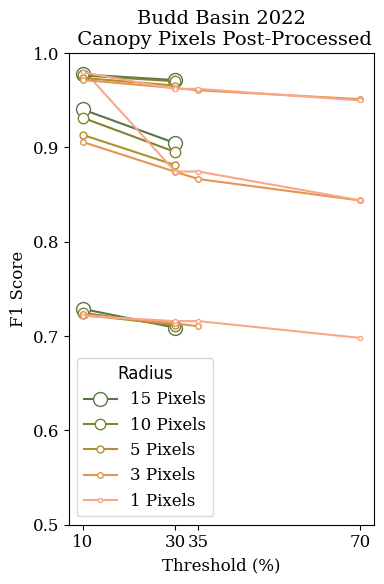

In [57]:
# Ensure 'radius' and 'threshold' columns are numeric
metrics['radius'] = pd.to_numeric(metrics['radius'], errors='coerce')
metrics['threshold'] = pd.to_numeric(metrics['threshold'], errors='coerce')

year = 2022
fig, ax = plt.subplots(figsize=(4, 6))
plt.rcParams['font.size'] = 12
plt.csfont = {'fontname': 'serif'}

rad_sizes = [1, 3, 5, 10, 15]
num_radii = metrics['radius'].nunique()
colors = cmc.batlow(np.linspace(.4, .8, num_radii))

ps_dates = np.sort(metrics['ps_date'].unique())
plotted_radii = set()
print(ps_dates)
# Marker size config (min should be smaller than max)
min_marker_size = 10
max_marker_size = 3

sorted_radii = sorted(metrics['radius'].unique(), reverse=True)
radius_to_color = dict(zip(sorted_radii, colors))

for date in ps_dates:
    date_data = metrics[metrics['ps_date'] == date]
    
    for radius in sorted_radii:
        radius_data = date_data[date_data['radius'] == radius]
        radius_data = radius_data.sort_values('threshold')  

        if radius_data.empty:
            continue

        # Marker size scaling
        marker_size = max_marker_size - (radius - min(rad_sizes)) * (max_marker_size - min_marker_size) / (max(rad_sizes) - min(rad_sizes))

        color = radius_to_color[radius]
        if radius not in plotted_radii:
            ax.plot(radius_data['threshold'], radius_data['f1'], 
                                               label=f'{radius} Pixels', color=color, marker='o', markerfacecolor='white', markersize=marker_size)
            plotted_radii.add(radius)

        else:
            ax.plot(radius_data['threshold'], radius_data['f1'], 
                                   color=color, marker='o', markerfacecolor='white', markersize=marker_size)

# Axis settings
ax.set_xlabel("Threshold (%)", fontname='serif')
ax.set_ylabel("F1 Score", fontname='serif')
ax.set_ylim(0.5, 1)
ax.set_title(f"Budd Basin {year}\n Canopy Pixels Post-Processed", fontsize=14, fontname='serif')

sorted_thresholds = sorted(metrics['threshold'].dropna().unique())
ax.set_xticks(sorted_thresholds)

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontname('serif')

ax.legend(title="Radius", prop={'family': 'serif', 'size': 12})
plt.tight_layout()

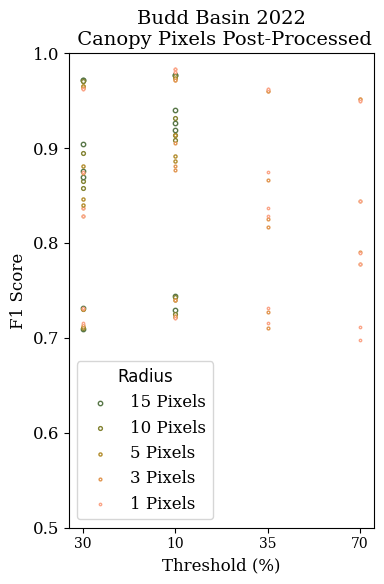

In [32]:
# Ensure 'radius' column is numeric (convert if necessary)
year = 2022
metrics['radius'] = pd.to_numeric(metrics['radius'], errors='coerce')

# Initialize the plot
fig, ax = plt.subplots(figsize=(4, 6))
plt.rcParams['font.size'] = 12
plt.csfont = {'fontname':'serif'}
rad_sizes = [1, 3,5,10,15]
# Define the number of unique radii
num_radii = metrics['radius'].nunique()

# Generate colors using the `batlow` colormap from cmcrameri
colors = cmc.batlow(np.linspace(.4, .8, num_radii))

# Sort dates for consistent plotting
ps_dates = np.sort(metrics['ps_date'].unique())

# Set to keep track of plotted radius labels
plotted_radii = set()

# Create a scaling factor for marker sizes (you can adjust this factor as needed)
max_marker_size = 3 # Max marker size
min_marker_size = 10   # Min marker size
# Sort dates for consistent plotting
# ps_dates = np.sort(metrics['ps_date'].unique())

# Sort radii in descending order
sorted_radii = sorted(metrics['radius'].unique(), reverse=True)
# Loop over each date
for i, date in enumerate(ps_dates):
    date_data = metrics[metrics['ps_date'] == date]

    # Loop over each unique radius within the date, sorted in descending order
    for j, radius in enumerate(sorted_radii):
        radius_data = date_data[date_data['radius'] == radius]

        # Calculate marker size (inverse scaling with radius size)
        marker_size = max_marker_size - (radius - np.min(rad_sizes)) * (max_marker_size - min_marker_size) / (np.max(rad_sizes) - np.min(rad_sizes))

        # Only add label to the legend if this radius hasn't been plotted before
        if radius not in plotted_radii:
            ax.scatter(radius_data['threshold'], radius_data['f1'], 
                                label=f'{radius} Pixels', color=colors[j], marker='o', facecolors='white', s=marker_size)
            plotted_radii.add(radius)  # Mark this radius as plotted
        else:
            ax.scatter(radius_data['threshold'], radius_data['f1'], 
                                color=colors[j], marker='o', facecolors='white', s=marker_size)

# Add labels and title
ax.set_xlabel("Threshold (%)",fontname='serif')
ax.set_ylabel("F1 Score",fontname='serif')
ax.set_ylim(0.5, 1)
ax.set_title(f"Budd Basin {year}\n Canopy Pixels Post-Processed", fontsize= 14,fontname='serif')
ax.tick_params(axis='x', labelsize=10, labelrotation=0)  # Adjust label size and rotation if needed
for label in ax.get_xticklabels():
    label.set_fontname('serif')
for label in ax.get_yticklabels():
    label.set_fontname('serif')
# Place legend to the side, sorted by radius in descending order
ax.legend(title="Radius", prop={'family': 'serif', 'size': 12})  #bbox_to_anchor=(1.05, 1)


plt.tight_layout()

## difference maps

In [11]:
def calc_false_color(ds):
    # Selecting RGB bands
    blue_band = ds.isel(band=0)
    green_band = ds.isel(band=1)
    red_band = ds.isel(band=2)
    nir_band = ds.isel(band=3)
    
    # normalize
    maxval = green_band.max().values
    minval = green_band.min().values
    red_norm = (red_band - minval) / (maxval - minval)
    green_norm = (green_band - minval) / (maxval - minval)
    blue_norm = (blue_band - minval) / (maxval - minval)
    nir_norm = (nir_band - minval) / (maxval - minval)
    green_norm = green_norm.where(red_norm <= 1,1)
    blue_norm = blue_norm.where(red_norm <= 1,1)
    red_norm = red_norm.where(red_norm <= 1,1)
    nir_norm = nir_norm.where(red_norm <= 1,1)

    red_band = red_band.values
    green_band = green_band.values
    blue_band = blue_band.values
    nir_band = nir_band.values
    
    # Stack normalized bands to create RGB image
    false_image = np.stack([nir_norm, red_norm, green_norm], axis=-1)
    return red_band,green_band,blue_band,nir_band,false_image 

# calculate the rgb bands and normalize radiances
# see 1_classify_train_model.ipynb
def calc_rgb(ds):
    # Selecting RGB bands
    blue_band = ds.isel(band=0)
    green_band = ds.isel(band=1)
    red_band = ds.isel(band=2)
    nir_band = ds.isel(band=3)
    
    # normalize
    maxval = green_band.max().values
    minval = green_band.min().values
    red_norm = (red_band - minval) / (maxval - minval)
    green_norm = (green_band - minval) / (maxval - minval)
    blue_norm = (blue_band - minval) / (maxval - minval)
    green_norm = green_norm.where(red_norm <= 1,1)
    blue_norm = blue_norm.where(red_norm <= 1,1)
    red_norm = red_norm.where(red_norm <= 1,1)

    red_band = red_band.values
    green_band = green_band.values
    blue_band = blue_band.values
    nir_band = nir_band.values
    
    # Stack normalized bands to create RGB image
    rgb_image = np.stack([red_norm, green_norm, blue_norm], axis=-1)
    return red_band,green_band,blue_band,nir_band,rgb_image

In [ ]:
year = 2022
model = 'base'
fn = f'/home/etboud/projects/data/stacks/{name}_{model}_{year}_projected.nc'
pp_fn = f'/home/etboud/projects/data/stacks/{name}_{model}ST_{year}_3_50_NDVI_QAQC_smoothing.nc'

corr_fn = pd.read_csv('/home/etboud/projects/snow_mapping/corresponding_files_all.csv') # have not tested yet
corr_fn = corr_fn[corr_fn['model_run']=='V5']
corr_fn = corr_fn.drop(columns= ['model_file', 'model_run', 'raw_file','aso_file'])
corr_fn = corr_fn[corr_fn['aso_date'].astype(str).str[:4]== str(year)]
corr_fn = corr_fn.drop_duplicates()
corr_fn = corr_fn.sort_values(by=corr_fn.columns.tolist())
corr_fn.reset_index(inplace=True)
len(corr_fn)
ps = xr.open_dataset(fn)
pp = xr.open_dataset(pp_fn)


# Custom colormaps
listed_cmap = ListedColormap(['lightblue'])
listed_cmap.set_bad(color='none')

listed_cmap_diff = ListedColormap(['steelblue', 'white', 'orangered'])


fig, ax = plt.subplots(len(corr_fn), 5, figsize=(12, len(corr_fn)*4), squeeze=False)

for index, row in corr_fn.iterrows():
    print(index)
    times = ps['data'].time.values
    target_time = np.datetime64(row['ps_date'])

    matching_indices = np.where(times == target_time)[0]
    if len(matching_indices) == 0:
        # fallback, e.g. nearest match
        diffs = np.abs(times - target_time)
        matching_indices = [diffs.argmin()]
    model_slice = ps['data'].isel(time=matching_indices[0])
    model_slice_pp = pp['data'].isel(time=matching_indices[0])     
    aso_slice = aso['data'].sel(time=pd.to_datetime(row['aso_date']))
    model_diff = model_slice - aso_slice
    model_diff_pp = model_slice_pp - aso_slice
    model_slice = ma.masked_where(model_slice == 0, model_slice)
    model_slice_pp = ma.masked_where(model_slice_pp == 0, model_slice_pp)
    aso_slice = ma.masked_where(aso_slice == 0, aso_slice) 
    model_diff = np.where(model_diff == 1,0, model_diff)
    print(np.unique(model_diff))
    print(np.unique(model_diff_pp))
    # model_diff_pp = np.where(model_diff_pp == 1,0, model_diff_pp)
    ax[index, 0].imshow(model_slice, cmap=listed_cmap)
    ax[index, 0].set_title(f"{model}", fontsize=12)
    ax[index, 0].set_ylabel(f"{row['ps_date']}", fontsize=12)
    
    ax[index, 1].imshow(model_slice_pp, cmap=listed_cmap)
    ax[index, 1].set_title(f"{model} PP", fontsize=12)

    ax[index, 2].imshow(aso_slice, cmap=listed_cmap)
    ax[index, 2].set_title(f"ASO Slice", fontsize=12)

    ax[index, 3].imshow(model_diff, cmap=listed_cmap_diff, vmin=-1, vmax=1)
    ax[index, 3].set_title(f"{model} - ASO", fontsize=12)

    ax[index, 4].imshow(model_diff_pp, cmap=listed_cmap_diff, vmin=-1, vmax=1)
    ax[index, 4].set_title(f"{model} S+T - ASO", fontsize=12)

    ax[index, 0].set_ylabel(f"{row['ps_date']}", fontsize=12)
    for j in range(5):
        ax[index, j].set_xticks([])
        ax[index, j].set_yticks([])
plt.tight_layout()
    


In [4]:
year = 2020
corr_fn = pd.read_csv('/home/etboud/projects/snow_mapping/corresponding_files_all.csv') # have not tested yet
corr_fn = corr_fn[corr_fn['model_run']=='V5']
corr_fn = corr_fn.drop(columns= ['model_file', 'model_run', 'raw_file','aso_file'])
corr_fn = corr_fn.drop_duplicates()
corr_fn = corr_fn[corr_fn['aso_date'].astype(str).str[:4]== str(year)]
corr_fn = corr_fn.sort_values(by=corr_fn.columns.tolist())
corr_fn.reset_index(inplace=True)
len(corr_fn)
data_direc = f'/data0/images/planet/emma/planet/BUDD/'

In [5]:
corr_fn

,index,aso_date,ps_date
0,39,2020-04-13,2020-04-13
1,40,2020-05-07,2020-05-06
2,41,2020-05-21,2020-05-23


In [6]:

data_direc = f'/data0/images/planet/emma/planet/BUDD/'
subdirecs = sorted([d for d in glob.glob(data_direc + str(year) + '*') if os.path.isdir(d)])
for dCount,direcc in enumerate(subdirecs):
    if '2020430' in direcc:
        fname = glob.glob(direcc+'/*/PSScene/*SR_clip.tif')[0]
        code = direcc.split('/')[-1]
        image = rxr.open_rasterio(fname).rio.clip(basin.geometry, drop=True, all_touched=True)
        _,_,_,_,false_image = calc_false_color(image)

In [12]:
import numpy.ma as ma
year = 2020
name = 'BUDD'
fn = f'/home/etboud/projects/data/stacks/sep/{name}_base_{year}_projected.nc'
pp_fn = f'/home/etboud/projects/data/stacks/sep/{name}_baseS_{year}_3_50_NDVI_QAQC_spatial.nc'
comp_fn = f'/home/etboud/projects/data/stacks/sep/{name}_composite_{year}_projected.nc'
ps = xr.open_dataset(fn)
pp = xr.open_dataset(pp_fn)
comp = xr.open_dataset(comp_fn)
ps_time = '2020-04-13T00:00:00.000000000'
aso_time = '2020-04-13T00:00:00.000000000'
str_time = ps_time.split('T')[0].replace('-', '')
data_direc = f'/data0/images/planet/emma/planet/BUDD/'
subdirecs = sorted([d for d in glob.glob(data_direc + str(year) + '*') if os.path.isdir(d)])
for dCount,direcc in enumerate(subdirecs):
    if str_time in direcc:
        fname = glob.glob(direcc+'/*/PSScene/*SR_clip.tif')[0]
        code = direcc.split('/')[-1]
        image = rxr.open_rasterio(fname).rio.clip(basin.geometry, drop=True, all_touched=True)
        _,_,_,_,false_image = calc_false_color(image)
        _,_,_,_,rgb_image = calc_rgb(image)
        
model_slice = ps['data'].sel(time=ps_time)
model_slice_pp = pp['data'].sel(time=ps_time)     
aso_slice = aso['data'].sel(time=aso_time)
comp_slice = comp['data'].sel(time=ps_time)
model_diff = model_slice - aso_slice
model_diff_pp = model_slice_pp - aso_slice
model_diff_comp = comp_slice - aso_slice
# Mask 0s (non-snow areas)
model_slice = ma.masked_where(model_slice == 0, model_slice)
model_slice_pp = ma.masked_where(model_slice_pp == 0, model_slice_pp)
comp_slice = ma.masked_where(comp_slice == 0, comp_slice)
aso_slice = ma.masked_where(aso_slice == 0, aso_slice)
false_image = np.where(false_image == 0, np.nan, false_image)
rgb_image = np.where(rgb_image == 0, np.nan, rgb_image)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.17694516614248598..1.4357992615889512].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.17694516614248598..1.4357992615889512].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.17694516614248598..1.4357992615889512].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.17694516614248598..1.4357992615889512].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.17694516614248598..1.4357992615889512].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.17694516614248598..1.4357992615889512].


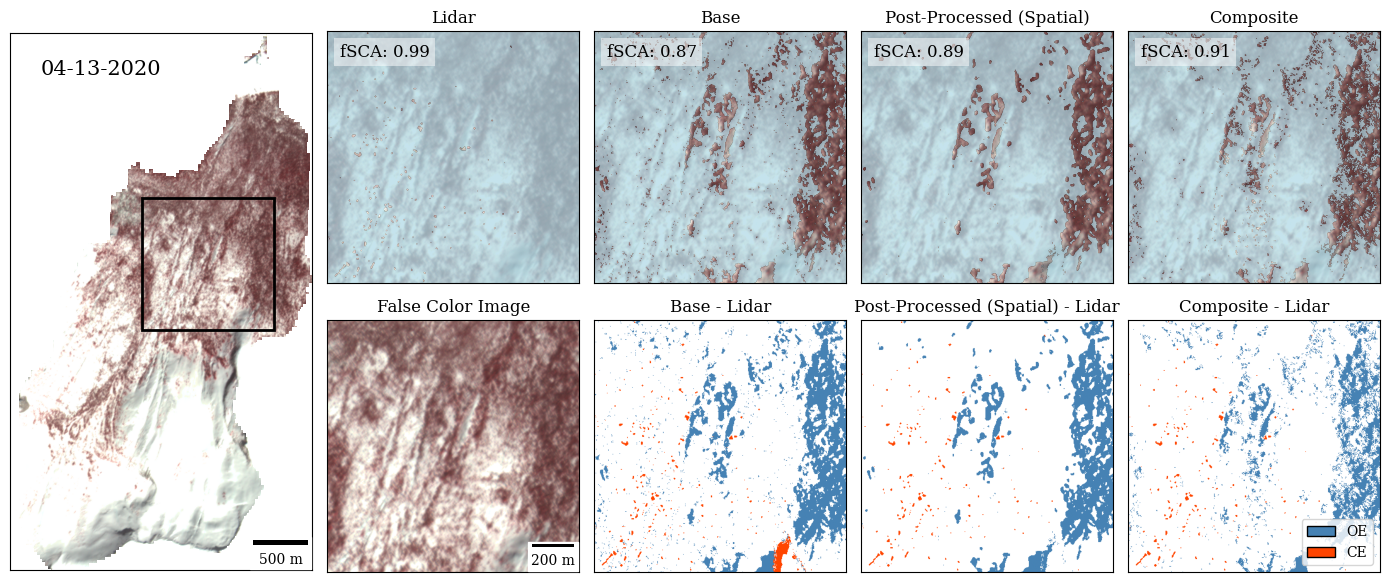

In [35]:
# 2023-04-26
fig = plt.figure(figsize=(14, 6))
plt.rcParams['font.family'] = 'serif'
listed_cmap = ListedColormap(['lightblue'])
listed_cmap.set_bad(color='none')

listed_cmap_diff = ListedColormap(['steelblue', 'white', 'orangered'])

false_cmap = plt.cm.gray
false_cmap.set_bad(color='white')

# Create a 2-row, 5-column grid
gs = fig.add_gridspec(2, 5, height_ratios=[1, 1], width_ratios=[1.2, 1, 1, 1, 1])

# First subplot: spans both rows in the first column
ax0 = fig.add_subplot(gs[:, 0])  # All rows in column 0
ax0.imshow(false_image, cmap='gray')


ax1 = fig.add_subplot(gs[0, 1], label='ASO Slice')
ax1.imshow(false_image, cmap='gray')
ax1.imshow(aso_slice, cmap=listed_cmap, alpha = 0.7)
ax2 = fig.add_subplot(gs[1, 1], label='False Color Image')
ax2.imshow(false_image, cmap='gray')
# Next 6 subplots (2 rows × 3 columns) in columns 1, 2, 3
ax3 = fig.add_subplot(gs[0, 2],label='Base')
ax3.imshow(false_image, cmap='gray')
ax3.imshow(model_slice[0], cmap=listed_cmap, alpha=0.7)
ax4 = fig.add_subplot(gs[0, 3], label='Base PP (Spatial)')
ax4.imshow(false_image, cmap='gray')
ax4.imshow(model_slice_pp[0], cmap=listed_cmap, alpha=0.7)
ax5 = fig.add_subplot(gs[0, 4], label='Composite')
ax5.imshow(false_image, cmap='gray')
ax5.imshow(comp_slice[0], cmap=listed_cmap, alpha=0.7)
ax6 = fig.add_subplot(gs[1, 2], label='Base - ASO')
ax6.imshow(model_diff[0], cmap=listed_cmap_diff, vmin=-1, vmax=1)
ax7 = fig.add_subplot(gs[1, 3], label='Base PP (Spatial) - ASO')
ax7.imshow(model_diff_pp[0], cmap=listed_cmap_diff, vmin=-1, vmax=1)
ax8 = fig.add_subplot(gs[1, 4], label='Composite - ASO')
ax8.imshow(model_diff_comp[0], cmap=listed_cmap_diff, vmin=-1, vmax=1)

#add box in ax0
from matplotlib.patches import Rectangle
rect = Rectangle((400, 500), 400, 400, linewidth=2, edgecolor='black', facecolor='none')
ax0.add_patch(rect)
# add scalebar
from matplotlib_scalebar.scalebar import ScaleBar
scalebar = ScaleBar(dx=3, units='m', location='lower right', scale_loc='bottom', font_properties={'family': 'serif'})
scalebar1 = ScaleBar(dx=3, units='m', location='lower right', scale_loc='bottom', font_properties={'family': 'serif'})
ax0.add_artist(scalebar)
ax2.add_artist(scalebar1)
titles = [f'',
          'Lidar','False Color Image',
          'Base','Post-Processed (Spatial)',
        'Composite','Base - Lidar',
          'Post-Processed (Spatial) - Lidar','Composite - Lidar']
for i, (ax, title) in enumerate(zip([ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8], titles)):
    ax.set_title(title)
    ax.plot([0, 1], [0, i])  # Example plot
    ax.set_xticks([])
    ax.set_yticks([])
    
for ax in [ax1, ax2, ax3, ax4, ax5, ax6,ax7,ax8]:
    ax.set_xlim(400, 800)
    ax.set_ylim(900,500)
    
# custom legend with patch in bottom right subplot
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', edgecolor='black', label='OE'),
    Patch(facecolor='orangered', edgecolor='black', label='CE')
]
ax8.legend(handles=legend_elements, loc='lower right', fontsize=10, frameon=True)
# add text to ax2, ax3, ax4, ax5
ax0.text(0.1, 0.95, '04-13-2020', transform=ax0.transAxes, ha='left', va='top', fontsize=15, color='black', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
ax1.text(0.05, 0.95, 'fSCA: 0.99', transform=ax1.transAxes, ha='left', va='top', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
ax3.text(0.05, 0.95, 'fSCA: 0.87', transform=ax3.transAxes, ha='left', va='top', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
ax4.text(0.05, 0.95, 'fSCA: 0.89', transform=ax4.transAxes, ha='left', va='top', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
ax5.text(0.05, 0.95, 'fSCA: 0.91', transform=ax5.transAxes, ha='left', va='top', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
plt.tight_layout()
plt.show()

In [111]:


datasets = [ps, pp, comp, aso]
names = ['ps', 'pp', 'comp', 'aso']  # If you want to track dataset names

for name, ds in zip(names, datasets):
    # Select a time slice first (e.g., time index 0)
    time_slice = ds.sel(time=ps_time)

    # Now spatially subset using pixel indices for y and x
    # For example, take y pixels 400 to 800, x pixels 200 to 600
    subset = time_slice.isel(
        y=slice(400, 800),
        x=slice(500, 900)
    )


    print(np.unique(subset['data'].values))

    data_vals = subset['data'].values

    snow = np.nansum(data_vals == 1)
    nosnow = np.nansum(data_vals == 0)
    unobs = np.nansum(data_vals == 2)

    fsca = snow / (snow + nosnow + unobs) if (snow + nosnow + unobs) > 0 else np.nan

    print({'name':name,'snow': snow, 'nosnow': nosnow, 'unobs': unobs, 'fsca': round(fsca, 3)})

[ 0.  1.  2. nan]
{'name': 'ps', 'snow': 274619, 'nosnow': 42247, 'unobs': 24, 'fsca': 0.867}
[ 0.  1. nan]
{'name': 'pp', 'snow': 280877, 'nosnow': 36013, 'unobs': 0, 'fsca': 0.886}
[ 0.  1. nan]
{'name': 'comp', 'snow': 287408, 'nosnow': 29482, 'unobs': 0, 'fsca': 0.907}
[ 0.  1. nan]
{'name': 'aso', 'snow': 158027, 'nosnow': 418, 'unobs': 0, 'fsca': 0.997}
